## Contents:

* [Introduction](#intro)

* [Model 4: Predict crimes as Violent/Property/Part 2 crimes](#model4)

   * [Feature Set 1: Hour, District, Month](#model4.1)
            
        * [Measure of individual class precision, recall](#model4.2)
        
            * [Over sampling/ Class Balancing methods](#model4.3)
                
                * [Class balancing method](#model4.4)
                
                    * [Measure of individual class precision-recall](#model4.5)
        
                * [Oversampling](#model4.6)
        
                    * [Measure of individual class precision-recall](#model4.7)
        
            * [Inferences](#model4.8)
        
   * [Feature Set 2: District, Hour, Month, Streetname](#model4.9)
        
        * [Measure of individual class precision, recall](#model4.10)
        
        * [Over sampling/ Class Balancing methods](#model4.11)
        
             * [Class balancing method](#model4.12)
        
             * [Oversampling](#model4.13)
        
                  * [Measure of individual class precision-recall](#model4.14)
            
   * [Grid Search](#model4.15)
        
   * [Possible Improvements](#model4.16)

<a id='intro'></a>

In [6]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [ ]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import cross_validation, metrics
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [5]:
df_boston = pd.read_pickle('df_boston.pkl')

<a id='model4'></a>

###  Model 4: Predict crimes as Violent/Property/Part 2 crimes

* The crimes were collapsed into 3 categories and a model was built to evaluate it.

1. Violent Crimes
2. Property crimes
3. Part 2 crimes

In [6]:
violent_crimes =['HOMICIDE', 'SEX OFFENCES', 'ROBBERY', 'AGGRAVATED ASSAULT']
property_crimes = ['BURGLARY', 'LARCENY', 'OTHER LARCENY', 'LARCENY FROM MOTOR VEHICLE','PROPERTY','ARSON','FIRE RELATED REPORTS'] 

In [7]:
df_model4 = df_boston

In [8]:
list_crimes = list()
for crime in df_model4.crime_category:
    if crime in violent_crimes:
        list_crimes.append(0)
    elif crime in property_crimes:
        list_crimes.append(1)
    else:
        list_crimes.append(2)
df_model4.crime_category = list_crimes

In [9]:
df_model4.crime_category.value_counts(normalize=True)

2    0.682022
1    0.272611
0    0.045367
Name: crime_category, dtype: float64

only 4% of the crimes are classified as violent crimes. 27% of them are property related. Rest are part 2 crimes.

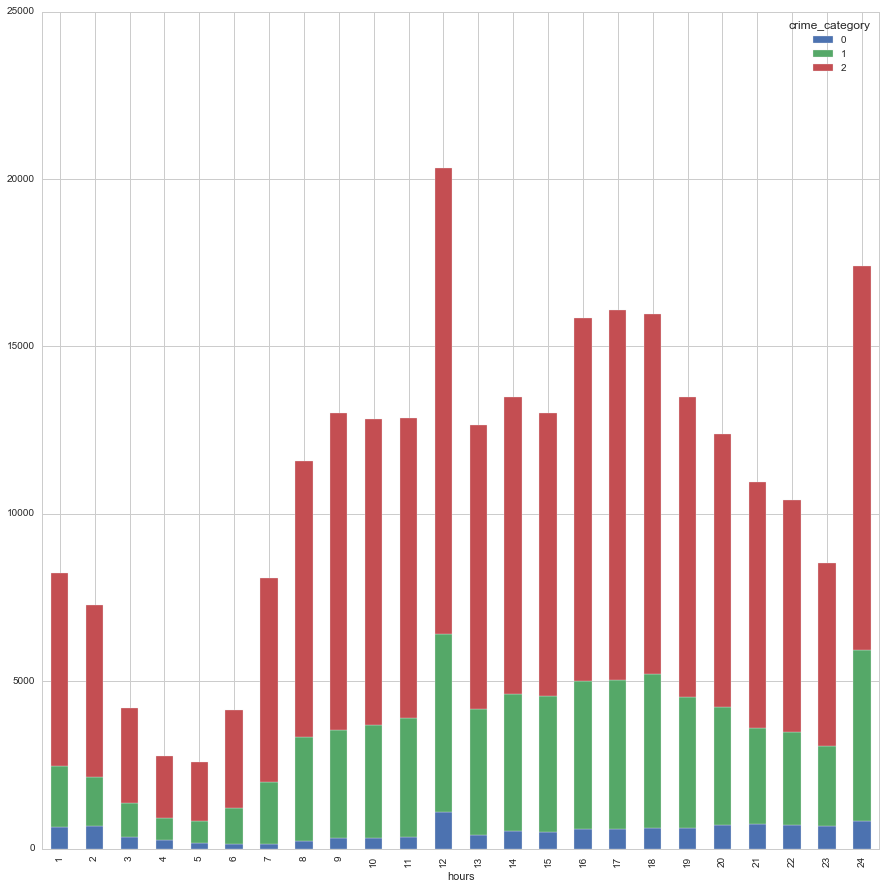

In [13]:
tmp=pd.DataFrame(df_model4.groupby(['hours','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='hours',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

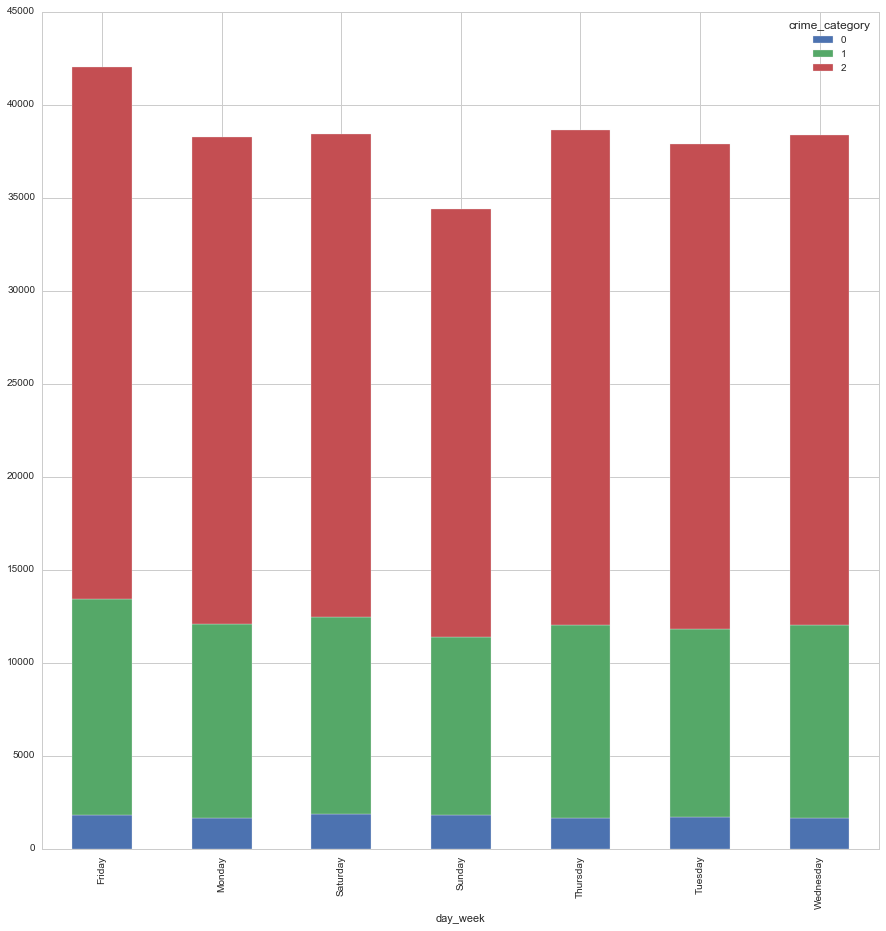

In [15]:
tmp=pd.DataFrame(df_model4.groupby(['day_week','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='day_week',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

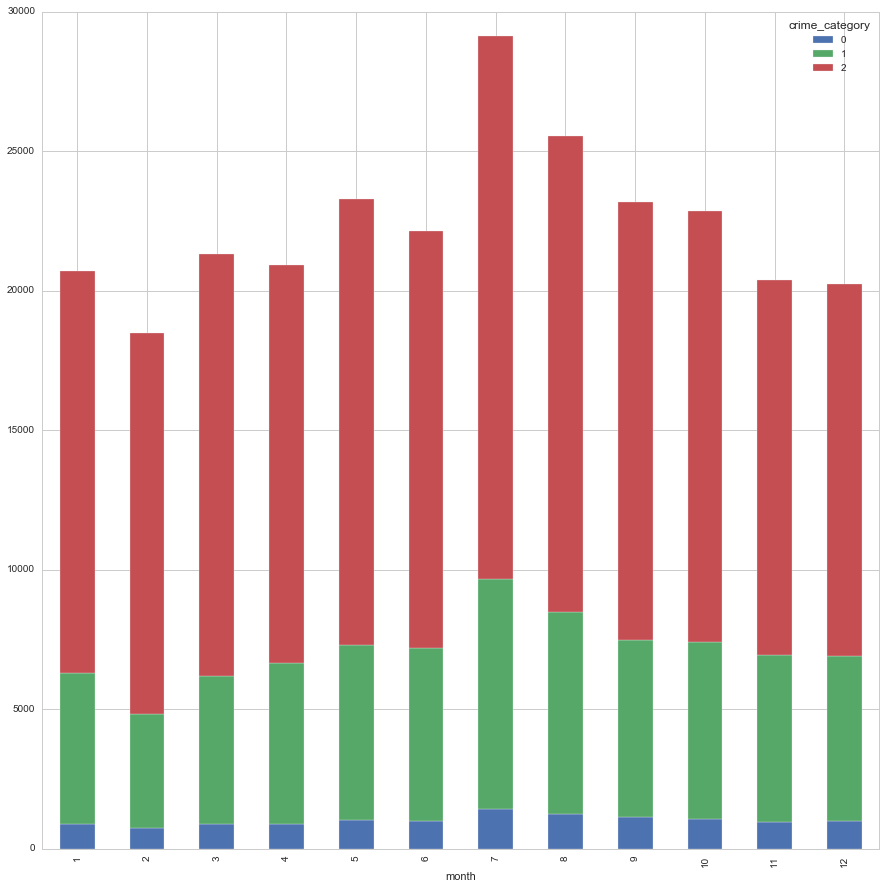

In [17]:
tmp=pd.DataFrame(df_model4.groupby(['month','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='month',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

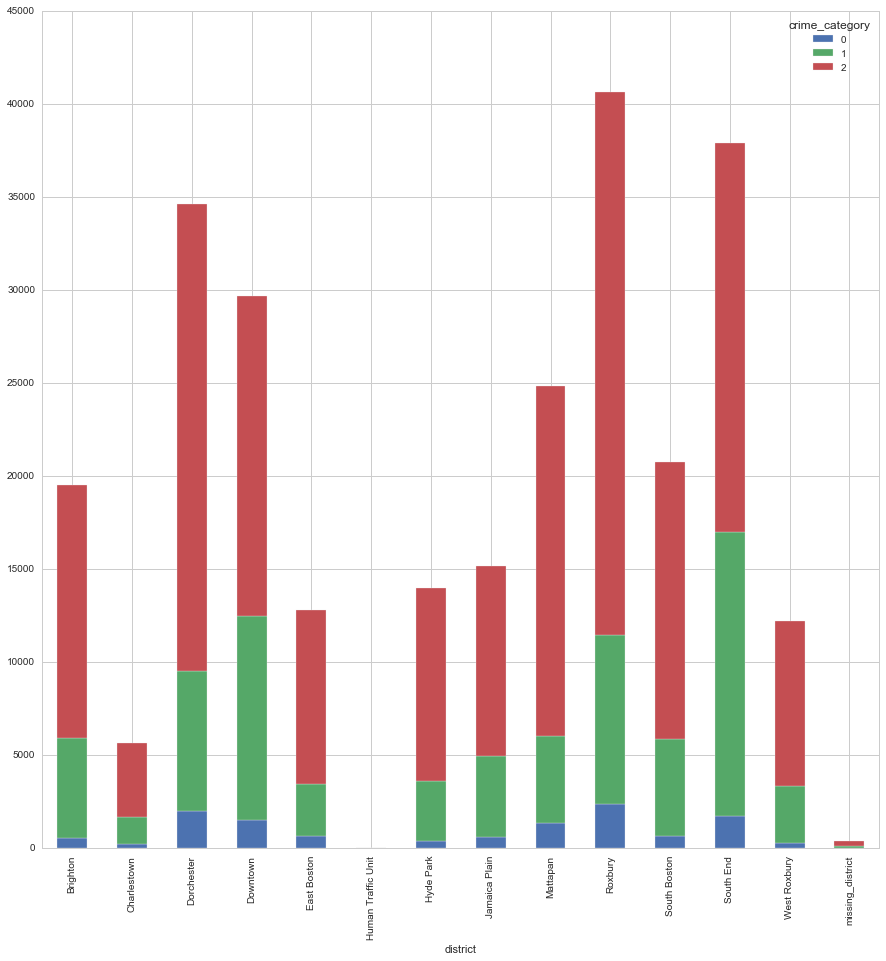

In [18]:
tmp=pd.DataFrame(df_model4.groupby(['district','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='district',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

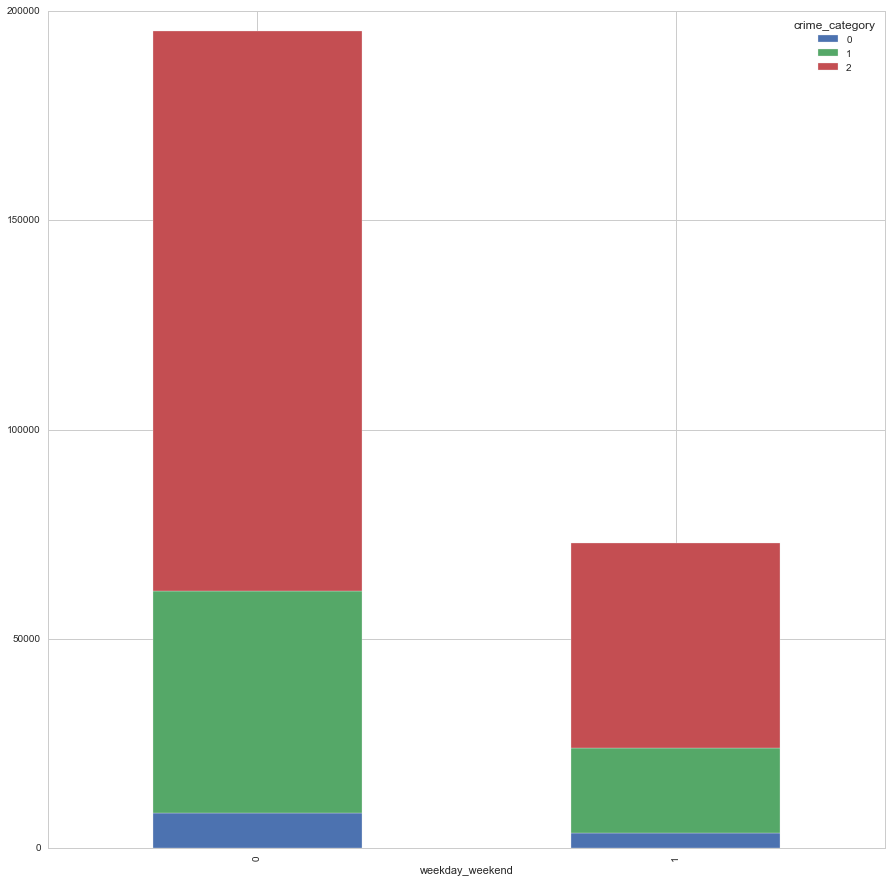

In [19]:
tmp=pd.DataFrame(df_model4.groupby(['weekday_weekend','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='weekday_weekend',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

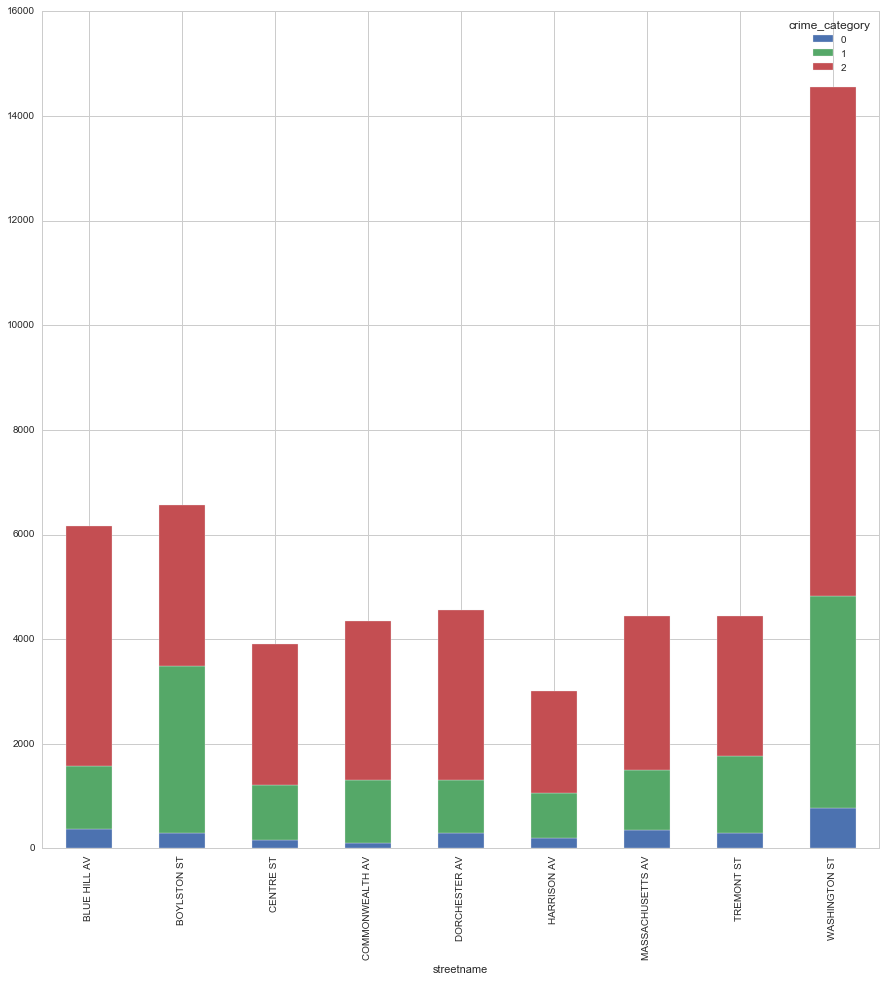

In [23]:
top_streets = list(df_boston.streetname.value_counts()[:9].index)
df_model4 = df_model4[df_model4['streetname'].isin(top_streets)]
tmp=pd.DataFrame(df_model4.groupby(['streetname','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='streetname',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

<a id='model4.1'></a>

#### Feature Set 1: District, Hour, Month

In [10]:
def encode_features_model4_set1(df):
    df_district = pd.get_dummies(df['district'])
    df_month = pd.get_dummies(df['month'])
    df_hours = pd.get_dummies(df['hours'])
    column_dfs = [df_district,df_month,df_hours]
    df_concat = pd.concat(column_dfs,axis=1)
    df_concat.columns = ['Brighton','Charlestown',
     'Dorchester',
     'Downtown',
     'East Boston',
     'Human Traffic Unit',
     'Hyde Park',
     'Jamaica Plain',
     'Mattapan',
     'Roxbury',
     'South Boston',
     'South End',
     'West Roxbury',
     'missing_district'] + ['month' + str(i) for i in range(1,13)] + ['hour' + str(i) for i in range(0,3)]
    return df_concat

In [11]:
def bin_hours_model4(df):
    list_hours = list()
    for hour in df.hours:
        if hour in range(1,7):
            list_hours.append(0)
        elif hour in [12,24]:
            list_hours.append(1)
        else:
            list_hours.append(2)
    df.hours = list_hours
    return df

In [12]:
df_model4_set1 = bin_hours_model4(df_model4)
data_y = df_model4_set1.crime_category
df_model4_set1 = encode_features_model4_set1(df_model4_set1)
data_x = df_model4_set1

In [13]:
def perform_cv(clf, X, Y, scoring_metric):
    kf_scores = list()
    scores = cross_validation.cross_val_score(clf, X, Y, cv=5, scoring=scoring_metric)
    kf_scores.append(scores)
    kf_scores.append(scores.mean())
    return kf_scores

In [14]:
def logistic_score(data_x,data_y,score,C):
    log_clf = make_pipeline(linear_model.LogisticRegression(multi_class='multinomial',solver='lbfgs',C=C))
    log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x,data_y,score)
    return log_kf_model2_set1_accuracy

In [15]:
def rf_score(data_x,data_y,score,number_trees,max_depth):
    rf_clf = make_pipeline(RandomForestClassifier(n_estimators=number_trees,max_depth=max_depth))
    rf_kf_model2_set1_accuracy = perform_cv(rf_clf,data_x,data_y,score)
    return rf_kf_model2_set1_accuracy

#### Logistic Regression

In [16]:
logistic_score(data_x,data_y,'accuracy',0.01)

[array([ 0.68201149,  0.67294025,  0.68202421,  0.67668949,  0.68202421]),
 0.67913793060569672]

In [18]:
logistic_score(data_x,data_y,'log_loss',0.01)

[array([-0.74143992, -0.76676755, -0.75030271, -0.75116526, -0.74109375]),
 -0.75015383763467025]

#### Random Forests

In [19]:
rf_score(data_x,data_y,'accuracy',150,20)

[array([ 0.68201149,  0.67445114,  0.68202421,  0.67182108,  0.68202421]),
 0.67846642662330503]

In [20]:
rf_score(data_x,data_y,'log_loss',150,20)

[array([-0.74089366, -0.76896178, -0.75150978, -0.75241038, -0.74419865]),
 -0.75159484885604222]

In [21]:
df = pd.DataFrame()
df['acc'] = [0.67913793060569672,0.67846642662330503]
df['log_loss'] = [ -0.75015,-0.751594848856]
df['alg'] = ['Logistic Regression','Random Forests']
df.set_index('alg')

,acc,log_loss
alg,,
Logistic Regression,0.679138,-0.750150
Random Forests,0.678466,-0.751595


* The log loss reported by both the algorithms are close to zero which is indicative of the good performance of the classifier in terms of the loss metric.
* The accuracies reported by the classifier are around 64% each.
* Why log-loss? - penalizes the false classifications. Depends on the probability assigned to each class than the most likely class, measures the accuracy in that sense. Ideal classifier has log loss of 0.
* Why accuracy 68% ? Due to class imbalance, the majority class dominates the classification. 

<a id='model4.2'></a>

#### Measure of individual class precision, recall

In [22]:
data_x_train, data_x_test, data_y_train, data_y_test = cross_validation.train_test_split(data_x, data_y, test_size=0.3, random_state=0)
clf = RandomForestClassifier(n_estimators=150,max_depth=20)
clf.fit(data_x_train,data_y_train)
expected = data_y_test
predicted = clf.predict(data_x_test)

In [24]:
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3615
          1       0.00      0.00      0.00     22066
          2       0.68      1.00      0.81     54736

avg / total       0.46      0.68      0.55     80417


Confusion matrix:
[[    0     0  3615]
 [    0     0 22066]
 [    0     0 54736]]


/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* As it can be seen from the confusion matrix, all the samples are assigned to class 2.

* The priority here is to have a greater precision in predicting class 0/1 crimes as they are part 1 crimes - more the sort of crime
whose prediction the BPD is more interested in.

<a id='model4.3'></a>

#### Class Balancing/Oversampling

<a id='model4.4'></a>

#### Class balancing method

In [25]:
log_clf = make_pipeline(linear_model.LogisticRegression(C=0.01, class_weight='balanced'))
log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x,data_y,'accuracy')
print log_kf_model2_set1_accuracy

[array([ 0.64269193,  0.62625208,  0.64540859,  0.63337748,  0.65203037]), 0.63995208934011816]


In [26]:
log_clf = make_pipeline(linear_model.LogisticRegression(C=0.01, class_weight='balanced'))
log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x,data_y,'f1')
print log_kf_model2_set1_accuracy

/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

[array([ 0.61478989,  0.59987227,  0.60492404,  0.60835449,  0.61320683]), 0.60822950703857059]


/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<a id='model4.5'></a>

#### Measure of individual class precision-recall

In [27]:
data_x_train, data_x_test, data_y_train, data_y_test = cross_validation.train_test_split(data_x, data_y, test_size=0.3, random_state=0)
clf = linear_model.LogisticRegression(C=0.01, class_weight='balanced')
clf.fit(data_x_train,data_y_train)
expected = data_y_test
predicted = clf.predict(data_x_test)

In [28]:
print("Classification report for classifier %s:\n%s\n"
      % (log_clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier Pipeline(steps=[('logisticregression', LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]):
             precision    recall  f1-score   support

          0       0.11      0.00      0.01      3615
          1       0.41      0.31      0.35     22066
          2       0.72      0.83      0.77     54736

avg / total       0.60      0.65      0.62     80417


Confusion matrix:
[[   11   726  2878]
 [   31  6862 15173]
 [   58  9296 45382]]


* Balancing class weights seems to improve the classfications for class 0/1 better.
* The precision for class 0 improves by 11% and for class 1, it improves by 41%

<a id='model4.6'></a>

#### Oversampling

In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
data_x_resampled, data_y_resampled = ros.fit_sample(data_x, data_y)

In [30]:
log_clf = make_pipeline(linear_model.LogisticRegression(C=0.01))
log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x_resampled,data_y_resampled,'accuracy')
print log_kf_model2_set1_accuracy

[array([ 0.35756482,  0.34286001,  0.34864894,  0.34175692,  0.35395471]), 0.34895707982350582]


In [31]:
log_clf = make_pipeline(linear_model.LogisticRegression(C=0.01))
log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x_resampled,data_y_resampled,'f1')
print log_kf_model2_set1_accuracy

/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

[array([ 0.3429252 ,  0.32772262,  0.33738882,  0.31646484,  0.34415675]), 0.33373164393758642]


/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


<a id='model4.7'></a>

#### Measure of individual class precision-recall

In [32]:
data_x_train, data_x_test, data_y_train, data_y_test = cross_validation.train_test_split(data_x_resampled, data_y_resampled, test_size=0.3, random_state=0)
clf = linear_model.LogisticRegression(C=0.01)
clf.fit(data_x_train,data_y_train)
expected = data_y_test
predicted = clf.predict(data_x_test)

In [33]:
print("Classification report for classifier %s:\n%s\n"
      % (log_clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier Pipeline(steps=[('logisticregression', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]):
             precision    recall  f1-score   support

          0       0.43      0.49      0.46     54924
          1       0.45      0.42      0.43     54757
          2       0.40      0.37      0.39     54857

avg / total       0.43      0.43      0.43    164538


Confusion matrix:
[[27111 13771 14042]
 [16133 23044 15580]
 [20108 14608 20141]]


* Oversampling improves it even more - the class 0 precision is improved by 43% while the class 1 precision improves by 45%.

<a id='model4.8'></a>

#### Inferences:

* The class imbalance seems to cause low precision-recall across classes.
* Oversampling the minor classes looks to improve the precision-recall scores for the classes.

<a id='model4.9'></a>

#### Feature Set 2: Add StreetNames

In [34]:
def encode_features_model4_set2(df):
    df_district = pd.get_dummies(df['district'])
    df_month = pd.get_dummies(df['month'])
    df_hours = pd.get_dummies(df['hours'])
    df_streetname = pd.get_dummies(df['streetname'])
    column_dfs = [df_district,df_month,df_hours,df_streetname]
    df_concat = pd.concat(column_dfs,axis=1)
    df_concat.columns = ['Brighton','Charlestown',
     'Dorchester',
     'Downtown',
     'East Boston',
     'Human Traffic Unit',
     'Hyde Park',
     'Jamaica Plain',
     'Mattapan',
     'Roxbury',
     'South Boston',
     'South End',
     'West Roxbury',
     'missing_district'] + ['month' + str(i) for i in range(1,13)]  + ['hour' + str(i) for i in range(0,3)] + ['street' + str(i) for i in range(0,10)]
    
    return df_concat

In [35]:
def recode_streetname(df):
    list_street = list()
    for street in df.streetname:
        if street not in top_streets:
            list_street.append('other')
        else:
            list_street.append(street)
    df.streetname = list_street
    return df

In [36]:
df_boston = pd.read_pickle('df_boston.pkl')
top_streets = list(df_boston.streetname.value_counts()[:9].index)

In [37]:
df_model4 = df_boston
list_crimes = list()
for crime in df_model4.crime_category:
    if crime in violent_crimes:
        list_crimes.append(0)
    elif crime in property_crimes:
        list_crimes.append(1)
    else:
        list_crimes.append(2)
df_model4.crime_category = list_crimes

In [40]:
df_model4_set2 = bin_hours_model4(df_model4)
df_model4_set2 = recode_streetname(df_model4_set2)
data_y = df_model4_set2.crime_category
df_model4_set2 = encode_features_model4_set2(df_model4_set2)
data_x = df_model4_set2

#### Logistic Regression

In [41]:
logistic_score(data_x,data_y,'accuracy',0.01)

[array([ 0.68436171,  0.67864804,  0.68334857,  0.67562627,  0.68465427]),
 0.68132777093615093]

In [42]:
logistic_score(data_x,data_y,'log_loss',0.01)

[array([-0.7401262 , -0.76506603, -0.74830222, -0.75032265, -0.74006204]),
 -0.74877582673958309]

#### Random Forests

In [43]:
rf_score(data_x,data_y,'accuracy',150,20)

[array([ 0.68549952,  0.68107291,  0.68659417,  0.68073716,  0.68597862]),
 0.68397647684424823]

In [44]:
rf_score(data_x,data_y,'log_loss',150,20)

[array([-0.74107096, -0.76718698, -0.75015533, -0.75166558, -0.74366043]),
 -0.75074785527059384]

In [7]:
df = pd.DataFrame()
df['algos'] = ['Logistic Regressions','Random Forests']
df['accuracy'] = [0.6813277,0.68397647]
df['log_loss'] = [-0.748775,-0.7507478552]
df.set_index('algos')

,accuracy,log_loss
algos,,
Logistic Regressions,0.681328,-0.748775
Random Forests,0.683976,-0.750748


* A small improvement in the log loss for the logistic regression is shown with the inclusion of the streetname as a feature.
* The log loss shows us that the class probabilities are on the edge even though they get assigned to class 2 completely.

<a id='model4.10'></a>

#### Measure of individual class precision-recall

In [45]:
data_x_train, data_x_test, data_y_train, data_y_test = cross_validation.train_test_split(data_x, data_y, test_size=0.3, random_state=0)
clf = RandomForestClassifier(n_estimators=150,max_depth=20)
clf.fit(data_x_train,data_y_train)
expected = data_y_test
predicted = clf.predict(data_x_test)

In [46]:
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):
             precision    recall  f1-score   support

          0       0.24      0.00      0.01      3615
          1       0.57      0.05      0.10     22066
          2       0.69      0.98      0.81     54736

avg / total       0.63      0.68      0.58     80417


Confusion matrix:
[[   14    67  3534]
 [   19  1186 20861]
 [   25   840 53871]]


* With the inclusion of streetname, the model makes a better classification for class 0 and 1 while due to class imbalance, the 
majority class gets all the instances labelled to.

<a id='model4.11'></a>

#### Class Balancing/Oversampling

<a id='model4.12'></a>

#### Class balancing method

In [47]:
log_clf = make_pipeline(linear_model.LogisticRegression(C=0.01, class_weight='balanced'))
log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x,data_y,'accuracy')
print log_kf_model2_set1_accuracy

[array([ 0.65024621,  0.63388111,  0.6532055 ,  0.6374065 ,  0.65538789]), 0.64602544162125863]


In [48]:
log_clf = make_pipeline(linear_model.LogisticRegression(C=0.01, class_weight='balanced'))
log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x,data_y,'f1')
print log_kf_model2_set1_accuracy

/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

[array([ 0.61530604,  0.59994455,  0.61072028,  0.61080476,  0.61301274]), 0.60995767381437938]


/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


<a id='model4.13'></a>

#### Oversampling

In [49]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
data_x_resampled, data_y_resampled = ros.fit_sample(data_x, data_y)

In [50]:
log_clf = make_pipeline(linear_model.LogisticRegression(C=0.01))
log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x_resampled,data_y_resampled,'accuracy')
print log_kf_model2_set1_accuracy

[array([ 0.36333552,  0.35805711,  0.36252416,  0.34431864,  0.36316231]), 0.35827954636618892]


In [51]:
log_clf = make_pipeline(linear_model.LogisticRegression(C=0.01))
log_kf_model2_set1_accuracy = perform_cv(log_clf,data_x_resampled,data_y_resampled,'f1')
print log_kf_model2_set1_accuracy

/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

[array([ 0.34549342,  0.34109767,  0.34946639,  0.32117974,  0.35077345]), 0.34160213314535243]


/cise/homes/ashwin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


<a id='model4.14'></a>

#### Measure of individual class precision-recall

In [52]:
data_x_train, data_x_test, data_y_train, data_y_test = cross_validation.train_test_split(data_x_resampled, data_y_resampled, test_size=0.3, random_state=0)
clf = linear_model.LogisticRegression(C=0.01)
clf.fit(data_x_train,data_y_train)
expected = data_y_test
predicted = clf.predict(data_x_test)

In [53]:
print("Classification report for classifier %s:\n%s\n"
      % (log_clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier Pipeline(steps=[('logisticregression', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]):
             precision    recall  f1-score   support

          0       0.44      0.51      0.47     54924
          1       0.46      0.41      0.43     54757
          2       0.40      0.38      0.39     54857

avg / total       0.43      0.43      0.43    164538


Confusion matrix:
[[28078 12184 14662]
 [16370 22516 15871]
 [19804 14405 20648]]


#### Inferences:

* The class imbalance seems to cause low precision-recall across classes.
* Oversampling the minor classes looks to improve the precision-recall scores for the classes.
* The addition of the street feature looks to have improved the performance.

<a id='model4.15'></a>

#### Grid Search

In [96]:
from sklearn.grid_search import GridSearchCV

In [ ]:
data_x_train, data_x_test, data_y_train, data_y_test = cross_validation.train_test_split(data_x_resampled, data_y_resampled, test_size=0.3, random_state=0)
parameters = {'n_estimators':[200, 225, 250], 'max_depth':[20,25]}
scores = ['precision','recall','f1']
rf = RandomForestClassifier()
for score in scores:
    clf = GridSearchCV(rf, parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(data_x_train, data_y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = data_y_test, clf.predict(data_x_test)
    print(metrics.classification_report(y_true, y_pred))
    print()


Grid Search to find the best hyper parameter of random forest is performed: (250,25)

In [55]:
data_x_train, data_x_test, data_y_train, data_y_test = cross_validation.train_test_split(data_x_resampled, data_y_resampled, test_size=0.3, random_state=0)
clf = RandomForestClassifier(n_estimators=250,max_depth=25)
clf.fit(data_x_train,data_y_train)
expected = data_y_test
predicted = clf.predict(data_x_test)

In [56]:
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):
             precision    recall  f1-score   support

          0       0.46      0.56      0.50     54924
          1       0.48      0.41      0.44     54757
          2       0.42      0.37      0.39     54857

avg / total       0.45      0.45      0.45    164538


Confusion matrix:
[[31010 11051 12863]
 [16402 22582 15773]
 [20556 13849 20452]]


The average precision, recall and f1 has improved when compared to the earlier parameters.

<a id='model4.16'></a>

#### Possible Improvements:

* One hot encode classes to see improvements.
* Boosted trees and neural networks to improve performance.
* Experiment sampling techinques to improve class imbalance.